## **Preparing data**

In [1]:
##Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import random
from urllib import request
import nltk
import requests
from bs4 import BeautifulSoup
import re
from urllib import request
import nltk
import pandas as pd
import random
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import nltk
import random
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

## Preprocess and tokenize text
def preprocess_and_tokenize(text):
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [stemmer.stem(token.lower()) for token in tokens if token.lower() not in stop_words and token.isalpha()]
    preprocessed_text = ' '.join(cleaned_tokens)  # For the preprocessed column
    return preprocessed_text, cleaned_tokens

##Creating the samples
def create_samples(url_txt, label, n_samples=200, record_length=150):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_text = ' '.join(words[start_index:start_index + record_length])
        preprocessed_text, tokens = preprocess_and_tokenize(sample_text)

        samples.append({
            'Title': title,
            'Author': author,
            'Label': label,
            'Preprocessed_Text': preprocessed_text,
            'Tokens': tokens
        })

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)  # Generate labels a, b, c, ...
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

## Set a seed for reproducibility
random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Pre-processing the data

In [3]:
import nltk
import random
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

##Fetching the text using the url
def text_gutenberg(url_txt):
    response = requests.get(url_txt)
    raw = response.text

    start_regex = r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK'
    end_regex = r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK'

    start_match = re.search(start_regex, raw)
    end_match = re.search(end_regex, raw)

    if start_match and end_match:
        beginning = start_match.end()
        end_position = end_match.start()
        text = raw[beginning:end_position]
        return text
    else:
        print(f"Start or end pattern not found in {url_txt}")
        return ""

#finding the text's title and author
def get_book_info(url_text):
    try:
        response = requests.get(url_text)
        soup = BeautifulSoup(response.text, 'html.parser')

        content = soup.get_text()
        title_match = re.search(r'Title:\s*([^\n\r]+)', content)
        author_match = re.search(r'Author:\s*([^\n\r]+)', content)

        title = title_match.group(1).strip() if title_match else "Title not found"
        author = author_match.group(1).strip() if author_match else "Author not found"

        return title, author
    except Exception as e:
        return f"Error: {e}"

## Preprocess and tokenize text
def preprocess_and_tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokenizer = WordPunctTokenizer()

    tokens = tokenizer.tokenize(text)
    cleaned_tokens = [re.sub('[^a-zA-Z]', ' ', token) for token in tokens if token.lower() not in stop_words]
    cleaned_tokens = [token.lower().strip() for token in cleaned_tokens if token.strip()]
    preprocessed_tokens = lemmatisation(cleaned_tokens)
    #preprocessed_tokens = stemming(preprocessed_tokens)
    preprocessed_text = ' '.join(cleaned_tokens)
    return preprocessed_text, cleaned_tokens
## Lemmatisation (convert the word into root word)
def lemmatisation(token_list):
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  lem_txt = [lem.lemmatize(word) for word in token_list]
  return lem_txt

def stemming(token_list):
  ps = nltk.stem.porter.PorterStemmer()
  stem_txt = [ps.stem(word) for word in token_list]
  return stem_txt


##Creating the samples
def create_samples(url_txt, label, n_samples=200, record_length=150):
    text = text_gutenberg(url_txt)
    title, author = get_book_info(url_txt)

    words = text.split()
    total_length = len(words)
    used_indices = set()

    samples = []
    for _ in range(n_samples):
        start_index = get_non_overlapping_start_index(used_indices, record_length, total_length)
        used_indices.update(range(start_index, start_index + record_length))

        sample_text = ' '.join(words[start_index:start_index + record_length])
        preprocessed_text, tokens = preprocess_and_tokenize(sample_text)

        samples.append({
            'Title': title,
            'Author': author,
            'Label': label,
            'Preprocessed_Text': preprocessed_text,
            'Tokens': tokens
        })

    return samples

##Creating the dataframe
def create_dataframe(book_urls):
    all_samples = []

    for label, url in enumerate(book_urls, start=0):
        book_label = chr(97 + label)
        book_samples = create_samples(url, book_label)
        all_samples.extend(book_samples)

    df = pd.DataFrame(all_samples)
    return df

random.seed(42)

#Helper function to make sure functions don't overlap
def get_non_overlapping_start_index(used_indices, record_length, total_length, max_attempts=1000):
    attempt = 0
    while attempt < max_attempts:
        start_index = random.randint(0, total_length - record_length)
        if all(start_index not in range(index, index + record_length) for index in used_indices):
            return start_index
        attempt += 1
    raise ValueError("Unable to find a non-overlapping start index. Consider reducing sample size or record length.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
#Using 6 books of the fantasy genra
book_urls = ["https://www.gutenberg.org/cache/epub/1342/pg1342-images.html",
             "https://www.gutenberg.org/cache/epub/2489/pg2489-images.html",
             "https://www.gutenberg.org/cache/epub/43/pg43-images.html",
             "https://www.gutenberg.org/cache/epub/174/pg174-images.html",
             "https://www.gutenberg.org/cache/epub/1661/pg1661-images.html",
             "https://www.gutenberg.org/cache/epub/36/pg36-images.html"]
df = create_dataframe(book_urls)

df

,Title,Author,Label,Preprocessed_Text,Tokens
0,Pride and Prejudice,Jane Austen,a,saying p p people much said lucky master p p y...,"[saying, p, p, people, much, said, lucky, mast..."
1,Pride and Prejudice,Jane Austen,a,p div class figcenter style width px role figu...,"[p, div, class, figcenter, style, width, px, r..."
2,Pride and Prejudice,Jane Austen,a,result previous study things give miss austen ...,"[result, previous, study, things, give, miss, ..."
3,Pride and Prejudice,Jane Austen,a,tongue servants waited table judged better one...,"[tongue, servants, waited, table, judged, bett..."
4,Pride and Prejudice,Jane Austen,a,near relation patroness happened overhear gent...,"[near, relation, patroness, happened, overhear..."
...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot blood stained glass overturned water troug...,"[lot, blood, stained, glass, overturned, water..."
1196,The War of the Worlds,H. G. Wells,f,see look artilleryman detailed clearing people...,"[see, look, artilleryman, detailed, clearing, ..."
1197,The War of the Worlds,H. G. Wells,f,striking brevity p p martians alarmed approach...,"[striking, brevity, p, p, martians, alarmed, a..."
1198,The War of the Worlds,H. G. Wells,f,brutes said good god ugly brutes repeated p p ...,"[brutes, said, good, god, ugly, brutes, repeat..."


In [5]:
#Dataframe
import pandas as pd

author_to_genre = {
    'Jane Austen': 'Classic Romance',
    'Herman Melville': 'Adventure/Sea Story',
    'Robert Louis Stevenson': 'Psychological Thriller/Mystery',
    'Oscar Wilde': 'Philosophical Fiction',
    'Arthur Conan Doyle': 'Mystery/Detective Fiction',
    'H. G. Wells': 'Science Fiction'


}

def map_genre(author):
    return author_to_genre.get(author, 'Unknown')

df['Genre'] = df['Author'].apply(map_genre)

df

,Title,Author,Label,Preprocessed_Text,Tokens,Genre
0,Pride and Prejudice,Jane Austen,a,saying p p people much said lucky master p p y...,"[saying, p, p, people, much, said, lucky, mast...",Classic Romance
1,Pride and Prejudice,Jane Austen,a,p div class figcenter style width px role figu...,"[p, div, class, figcenter, style, width, px, r...",Classic Romance
2,Pride and Prejudice,Jane Austen,a,result previous study things give miss austen ...,"[result, previous, study, things, give, miss, ...",Classic Romance
3,Pride and Prejudice,Jane Austen,a,tongue servants waited table judged better one...,"[tongue, servants, waited, table, judged, bett...",Classic Romance
4,Pride and Prejudice,Jane Austen,a,near relation patroness happened overhear gent...,"[near, relation, patroness, happened, overhear...",Classic Romance
...,...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot blood stained glass overturned water troug...,"[lot, blood, stained, glass, overturned, water...",Science Fiction
1196,The War of the Worlds,H. G. Wells,f,see look artilleryman detailed clearing people...,"[see, look, artilleryman, detailed, clearing, ...",Science Fiction
1197,The War of the Worlds,H. G. Wells,f,striking brevity p p martians alarmed approach...,"[striking, brevity, p, p, martians, alarmed, a...",Science Fiction
1198,The War of the Worlds,H. G. Wells,f,brutes said good god ugly brutes repeated p p ...,"[brutes, said, good, god, ugly, brutes, repeat...",Science Fiction


#Word2Vec

In [6]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



seed = 42
model = Word2Vec(sentences=df['Tokens'].tolist(), vector_size=100, window=5, min_count=1, seed=seed, workers=4)

# Function to generate document vectors
def document_vector(word2vec_model, tokens):
    # Filter tokens to remove those not in the model's vocabulary
    tokens = [word for word in tokens if word in word2vec_model.wv.key_to_index]
    if not tokens:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model.wv[tokens], axis=0)

# Apply the document_vector function to generate vectors for each document
df['Doc_Vector'] = df['Tokens'].apply(lambda x: document_vector(model, x))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df

,Title,Author,Label,Preprocessed_Text,Tokens,Genre,Doc_Vector
0,Pride and Prejudice,Jane Austen,a,saying p p people much said lucky master p p y...,"[saying, p, p, people, much, said, lucky, mast...",Classic Romance,"[0.026390947, 0.12781872, 0.27212653, 0.349160..."
1,Pride and Prejudice,Jane Austen,a,p div class figcenter style width px role figu...,"[p, div, class, figcenter, style, width, px, r...",Classic Romance,"[-0.004754699, 0.083765745, 0.233798, 0.304608..."
2,Pride and Prejudice,Jane Austen,a,result previous study things give miss austen ...,"[result, previous, study, things, give, miss, ...",Classic Romance,"[0.048034415, 0.092671245, 0.13664787, 0.16683..."
3,Pride and Prejudice,Jane Austen,a,tongue servants waited table judged better one...,"[tongue, servants, waited, table, judged, bett...",Classic Romance,"[0.026565632, 0.09505311, 0.19131279, 0.236967..."
4,Pride and Prejudice,Jane Austen,a,near relation patroness happened overhear gent...,"[near, relation, patroness, happened, overhear...",Classic Romance,"[0.05273049, 0.11217472, 0.17777658, 0.2225350..."
...,...,...,...,...,...,...,...
1195,The War of the Worlds,H. G. Wells,f,lot blood stained glass overturned water troug...,"[lot, blood, stained, glass, overturned, water...",Science Fiction,"[0.059720147, 0.10859469, 0.1563674, 0.1888256..."
1196,The War of the Worlds,H. G. Wells,f,see look artilleryman detailed clearing people...,"[see, look, artilleryman, detailed, clearing, ...",Science Fiction,"[0.048810363, 0.12455968, 0.22166951, 0.280837..."
1197,The War of the Worlds,H. G. Wells,f,striking brevity p p martians alarmed approach...,"[striking, brevity, p, p, martians, alarmed, a...",Science Fiction,"[0.030141141, 0.07796939, 0.13701515, 0.173614..."
1198,The War of the Worlds,H. G. Wells,f,brutes said good god ugly brutes repeated p p ...,"[brutes, said, good, god, ugly, brutes, repeat...",Science Fiction,"[0.06887295, 0.14215587, 0.22645429, 0.2801728..."


#Clustering algorithmes

In [8]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
import numpy as np

In [10]:
X = np.stack(df['Doc_Vector'].values)

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
df['KMeans_Clusters'] = kmeans_labels


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


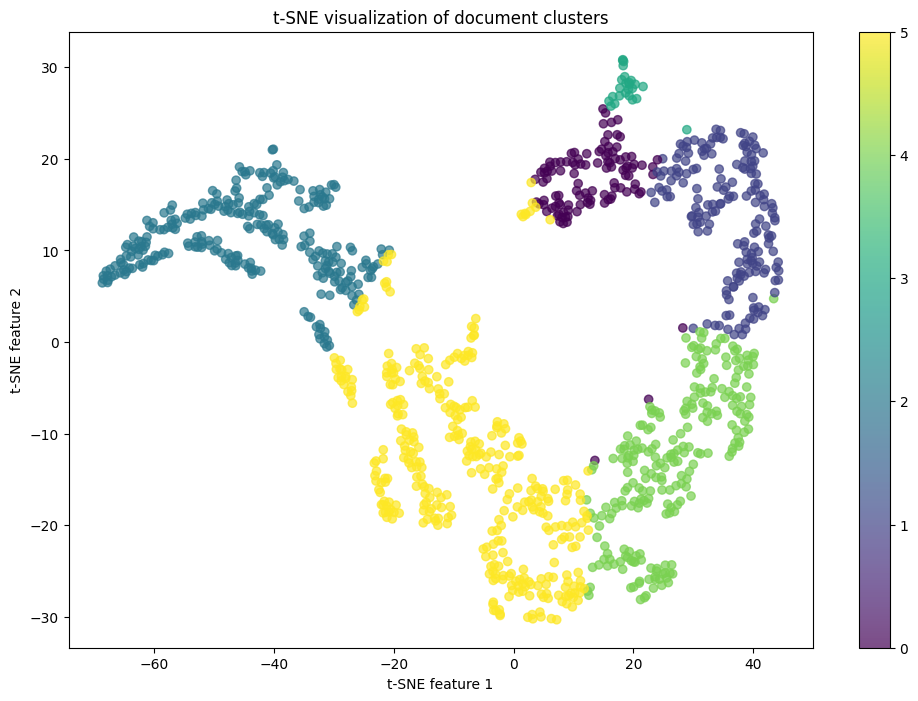

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

X_tsne = tsne.fit_transform(X)
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', marker='o', alpha=0.7)


plt.colorbar()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of document clusters')
plt.show()


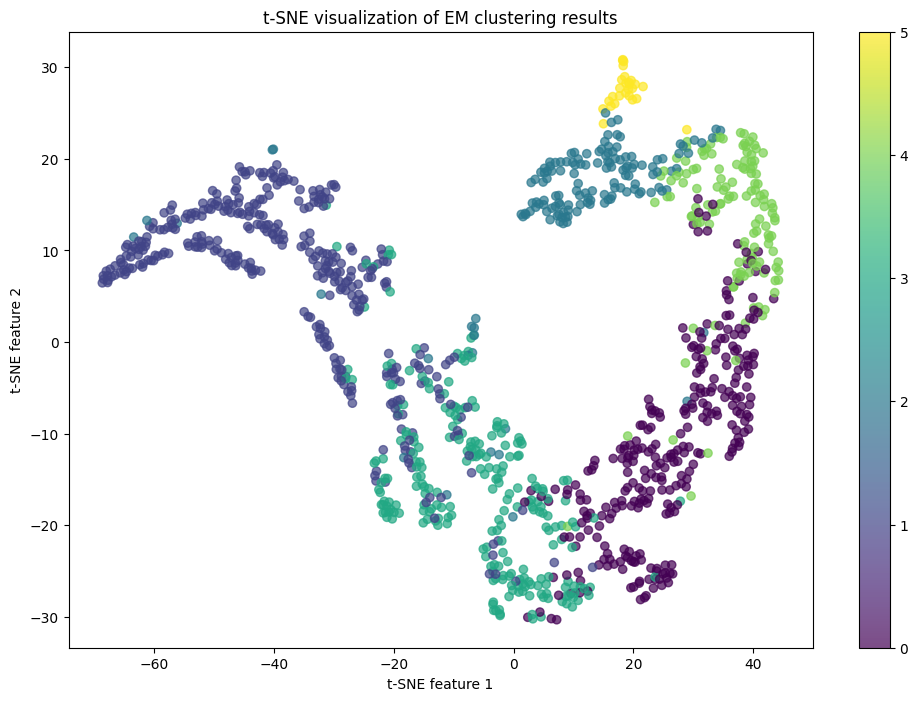

In [12]:
from sklearn.mixture import GaussianMixture

optimal_clusters = 6

gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X)
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels, cmap='viridis', marker='o', alpha=0.7)
plt.colorbar()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of EM clustering results')
plt.show()


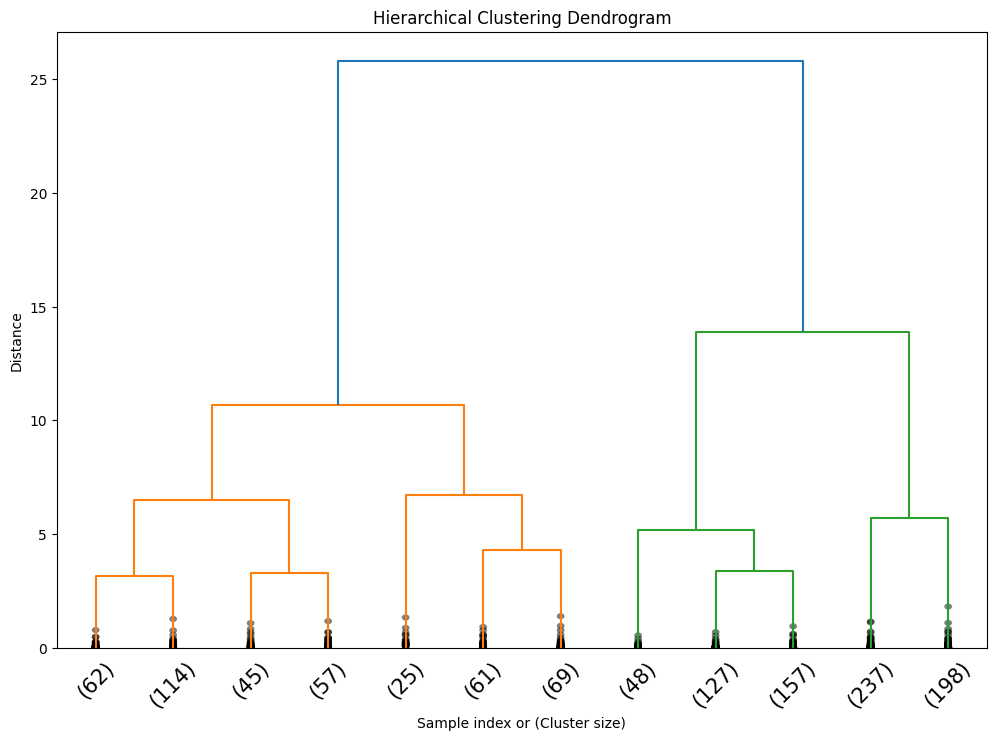

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(X, 'ward')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15.,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (Cluster size)')
plt.ylabel('Distance')
plt.show()


In [14]:
from scipy.cluster.hierarchy import fcluster

hierarchical_labels = fcluster(linkage_matrix, t=optimal_clusters, criterion='maxclust')


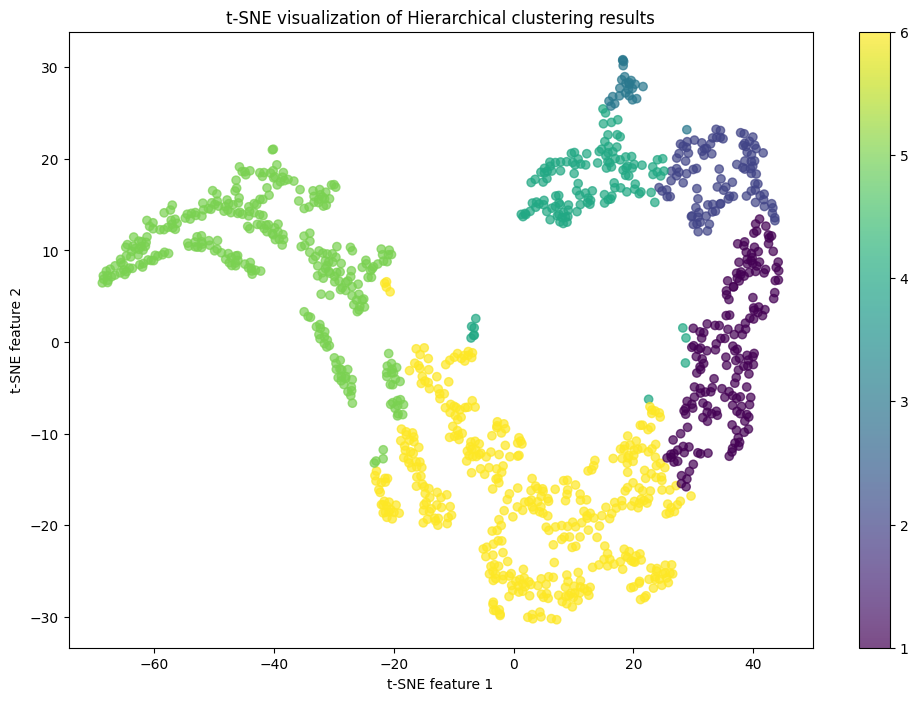

In [15]:
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_labels, cmap='viridis', marker='o', alpha=0.7)
plt.colorbar()
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE visualization of Hierarchical clustering results')
plt.show()


#Evaluation metrics

In [16]:
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelEncoder

def calculate_kappa(true_labels_encoded, cluster_labels):
    """
    Calculates Cohen's Kappa Score comparing true labels and clustering labels.

    Parameters:
    - true_labels_encoded: Encoded true labels (e.g., obtained using LabelEncoder).
    - cluster_labels: Cluster labels obtained from clustering algorithms.

    Returns:
    - kappa_score: Cohen's Kappa Score.
    """
    kappa_score = cohen_kappa_score(true_labels_encoded, cluster_labels)
    return kappa_score

# Corrected Kappa Scores calculation
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['Author'])

kappa_kmeans = calculate_kappa(true_labels_encoded, df['KMeans_Clusters'])
print(f"Cohen's Kappa Score (K-means): {kappa_kmeans}")

df['GMM_Clusters'] = gmm_labels
kappa_gmm = calculate_kappa(true_labels_encoded, df['GMM_Clusters'])
print(f"Cohen's Kappa Score (GMM): {kappa_gmm}")

df['Hierarchical_Clusters'] = hierarchical_labels
kappa_hierarchical = calculate_kappa(true_labels_encoded, df['Hierarchical_Clusters'])
print(f"Cohen's Kappa Score (Hierarchical): {kappa_hierarchical}")


Cohen's Kappa Score (K-means): 0.09699999999999998
Cohen's Kappa Score (GMM): 0.08999999999999986
Cohen's Kappa Score (Hierarchical): -0.04428904428904423


In [17]:
from sklearn.metrics import silhouette_score

silhouette_kmeans = silhouette_score(X, kmeans_labels)
print(f"Silhouette Score (K-means): {silhouette_kmeans}")

silhouette_gmm = silhouette_score(X, gmm_labels)
print(f"Silhouette Score (GMM): {silhouette_gmm}")

# Calculate Silhouette Score for Hierarchical Clustering
silhouette_hierarchical = silhouette_score(X, hierarchical_labels)
print(f"Silhouette Score (Hierarchical): {silhouette_hierarchical}")


Silhouette Score (K-means): 0.44569820165634155
Silhouette Score (GMM): 0.2797965407371521
Silhouette Score (Hierarchical): 0.4135805368423462
